In [ ]:
# https://blog.keras.io/building-autoencoders-in-keras.html

In [ ]:
'''
this one is simple auto encoder, without padding
'''

In [1]:

import os

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# root_path = r'gdrive/My Drive/work/research/AutoEncoder_classification/UTKFace/'  #change dir to your project folder

# os.chdir(root_path)

In [33]:
from tensorflow.keras.datasets import mnist

import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Cropping2D
from tensorflow.keras.layers import Flatten, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split


### 01 Get the data

In [5]:
# X=np.array(pickle.load(open("pickles/X_resized_grayed.p","rb")))
X=np.array(pickle.load(open("pickles/X_grayed_resized50.p","rb")))

In [6]:
y_genders=np.array(pickle.load(open("pickles/y_genders.p","rb")))
y_ages=np.array(pickle.load(open("pickles/y_ages.p","rb")))

In [7]:
X_adults=[]
y_genders_adults=[]
for i in range(len(X)):
    if y_ages[i]>18 and y_ages[i]<60:
        X_adults.append(X[i])
        y_genders_adults.append(y_genders[i])
X_adults=np.array(X_adults)
y_genders_adults=np.array(y_genders_adults)
X_adults=X_adults.reshape(len(X_adults),100,100,1)


In [8]:
# lim=1000
# X=X[:]
# y_genders=y_genders[:]
# X=X.reshape(len(X),34,34,1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X_adults, y_genders_adults, test_size=0.33,random_state=42)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# x_train=x_train.reshape(len(x_train),34,34,1)
# x_test=x_test.reshape(len(x_test),34,34,1)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(2828, 100, 100, 1) (2828,)
(1394, 100, 100, 1) (1394,)


In [11]:
autoenc_epochs=10
cnn_epochs=100

### 02 Create and train the model

In [ ]:
# input_img = keras.Input(shape=x_train[0].shape)

# x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# # at this point the representation is (4, 4, 8) i.e. 128-dimensional

# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# x = layers.UpSampling2D((2, 2))(x)

# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = Cropping2D(cropping=((1, 1), (1, 1)), data_format=None)(x) # this is the added step
# x = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# autoencoder = keras.Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='mse')

In [13]:
# from: https://github.com/rtflynn/Cifar-Autoencoder/blob/master/denoising_autoencoder.py

input_img = keras.Input(shape=x_train[0].shape)

x = layers.Conv2D(32, (3, 3),strides=1, activation='relu', padding='same')(input_img)
x = layers.BatchNormalization() (x)
x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
encoded = layers.BatchNormalization() (x)

# encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2,2))(encoded)
x = layers.Conv2D(32, (3, 3),strides=1, activation='relu',padding='same')(x)
x = layers.BatchNormalization() (x)

decoded = layers.Conv2D(1, (1, 1),strides=1, activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 100, 100, 32)      0     

In [14]:
history=autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/10
45/45 [==============================] - 61s 1s/step - loss: 0.0401 - accuracy: 0.0025 - val_loss: 0.0480 - val_accuracy: 0.0026
Epoch 2/10
45/45 [==============================] - 49s 1s/step - loss: 0.0014 - accuracy: 0.0027 - val_loss: 0.0437 - val_accuracy: 0.0029
Epoch 3/10
45/45 [==============================] - 46s 1s/step - loss: 0.0010 - accuracy: 0.0032 - val_loss: 0.0380 - val_accuracy: 0.0029
Epoch 4/10
45/45 [==============================] - 47s 1s/step - loss: 9.3264e-04 - accuracy: 0.0030 - val_loss: 0.0350 - val_accuracy: 0.0031
Epoch 5/10
45/45 [==============================] - 52s 1s/step - loss: 7.6064e-04 - accuracy: 0.0030 - val_loss: 0.0293 - val_accuracy: 0.0031
Epoch 6/10
45/45 [==============================] - 54s 1s/step - loss: 6.8546e-04 - accuracy: 0.0032 - val_loss: 0.0246 - val_accuracy: 0.0031
Epoch 7/10
45/45 [==============================] - 53s 1s/step - loss: 5.6001e-04 - accuracy: 0.0031 - val_loss: 0.0205 - val_accuracy: 0.0032
Epoc

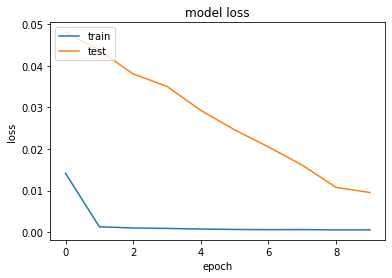

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

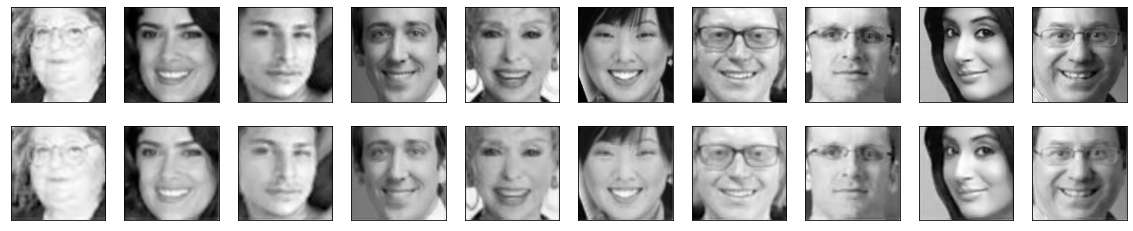

In [16]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(100,100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(100,100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


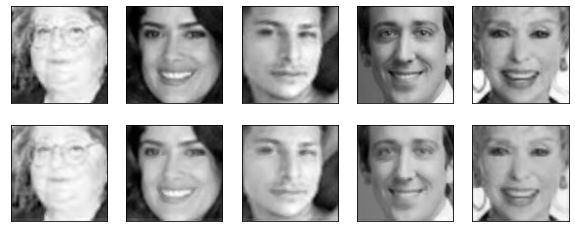

In [26]:
decoded_imgs = autoencoder.predict(x_test)

n = 5
plt.figure(figsize=(10, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(100,100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(100,100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# plt.show()
    plt.savefig("figures/utk_batchN_simple.svg")


In [18]:
autoencoder.save("models/batch_norm_autoenc_simple.h")

INFO:tensorflow:Assets written to: models/batch_norm_autoenc_simple.h/assets


In [20]:
# y_test[0]

#### 02a Save the encoder part

In [21]:
encoder = Model(inputs=input_img, outputs=encoded)
encoder.save('models/batch_norm_encoder_simple.h5')

### 03 Test encoded images with a LogReg

In [ ]:
def flatten_encoded_images_for_logreg(X_array):
    print(X_array.shape)
    X_array_flattened=[]
    for i in range(X_array.shape[0]):
        X_array_flattened.append(X_array[i].flatten())
    X_array_flattened=np.array(X_array_flattened)
    print("Shape is ",X_array_flattened.shape)
    return X_array_flattened

In [ ]:
# load the model from file
encoder = load_model('models/batch_norm_encoder_simple.h5')
# encode the train data
x_train_encode = encoder.predict(x_train)
x_train_encode_flat=flatten_encoded_images_for_logreg(x_train_encode)

# x_train_encode=x_train_encode.flatten()
print("Shape of encoded flat",x_train_encode_flat.shape)
# encode the test data
x_test_encode = encoder.predict(x_test)
x_test_encode_flat=flatten_encoded_images_for_logreg(x_test_encode)
print("Shape of encoded flat",x_test_encode_flat.shape)



In [ ]:
# define the model
model = LogisticRegression()
# fit the model on the training set
model.fit(x_train_encode_flat, y_train)
# make predictions on the test set
yhat = model.predict(x_test_encode_flat)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

### 04 Test encoded images with a CNN

In [ ]:
# https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

#### 04a Convert y values to categorical

In [27]:
#one-hot encode target column
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_train_one_hot.shape,y_test_one_hot.shape)

(2828, 2) (1394, 2)


#### 04b Extract features using encoder

In [28]:
# load the model from file
encoder = load_model('models/batch_norm_encoder_simple.h5')
# encode the train data
x_train_encode = encoder.predict(x_train)
print("Shape of training encoded images",x_train_encode.shape)

# encode the test data
x_test_encode = encoder.predict(x_test)
print("Shape of testing encoded images",x_test_encode.shape)


Shape of training encoded images (2828, 50, 50, 32)
Shape of testing encoded images (1394, 50, 50, 32)


In [29]:
print(x_train_encode[0].shape,x_test_encode[1].shape)

(50, 50, 32) (50, 50, 32)


### 04c create a CNN that takes encoded image as input

In [35]:
def get_model(x_train):
    # define a CNN to make the predictions
    #create model
    model = Sequential()#add model layers
    model.add(Conv2D(24, kernel_size=5, padding="same", activation='relu', input_shape=x_train[0].shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=5, padding="same", activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size=5, padding="same", activation='relu'))
    model.add(MaxPool2D(padding='same'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])    
    return model
    
# from: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
def define_model_VGG3(x_train):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=x_train[0].shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [36]:
acc_list=[]
for i in range(10):
    model=define_model_VGG3(x_train_encode)
    # print(model.summary())
    #train the model
    num_epochs=100
    history=model.fit(x_train_encode, y_train_one_hot, validation_data=(x_test_encode, y_test_one_hot), epochs=num_epochs,verbose=0)
    loss,acc=model.evaluate(x_test_encode, y_test_one_hot)
    print("Accuracy is ",acc)
    acc_list.append(acc)


44/44 [==============================] - 1s 32ms/step - loss: 0.3119 - accuracy: 0.9333
Accuracy is  0.9332855343818665
44/44 [==============================] - 2s 35ms/step - loss: 0.3005 - accuracy: 0.9347
Accuracy is  0.9347202181816101
44/44 [==============================] - 2s 34ms/step - loss: 0.2978 - accuracy: 0.9240
Accuracy is  0.9239598512649536
44/44 [==============================] - 2s 34ms/step - loss: 0.3514 - accuracy: 0.9232
Accuracy is  0.923242449760437
44/44 [==============================] - 1s 31ms/step - loss: 0.2714 - accuracy: 0.9390
Accuracy is  0.9390243887901306
44/44 [==============================] - 1s 26ms/step - loss: 0.3089 - accuracy: 0.9297
Accuracy is  0.9296987056732178
44/44 [==============================] - 1s 25ms/step - loss: 0.2531 - accuracy: 0.9419
Accuracy is  0.9418938159942627
44/44 [==============================] - 1s 27ms/step - loss: 0.2571 - accuracy: 0.9261
Accuracy is  0.9261119365692139
44/44 [==============================] - 

In [40]:
print(sum(acc_list)/len(acc_list))



0.9323529422283172


In [41]:
# 0.8368723034858704


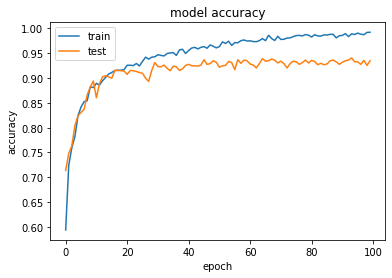

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()